In [3]:
print("H_W")

H_W


## Домашнее задание
1. Создать Dataset для загрузки данных (sklearn.datasets.fetch_california_housing)
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

## 1 Импортирование необходимых библиотек

In [4]:
import time
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## 2 Загрузка датасета с разбиением на основные признаки и целевую переменную

In [5]:
Housing = fetch_california_housing(as_frame=True)
feature, target = Housing.data, Housing.target

### 2.1 Просмотр размерностей датасетов

In [6]:
feature.shape, target.shape

((20640, 8), (20640,))

## 3 Запись датасета в DataFrame pandas для удобства просмотра и обработки информации

In [7]:
df = pd.DataFrame(feature)

In [8]:
df['target'] = target

In [9]:
df[:5]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### 3.1 Просмотр информации о датасете

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


### 3.2 Запись наименования признаков и их индексов в массив

In [11]:
col = df.columns.to_list()
col_info = []
for i in range(len(col)):
    col_info.append([i, col[i]])

In [12]:
col_info

[[0, 'MedInc'],
 [1, 'HouseAge'],
 [2, 'AveRooms'],
 [3, 'AveBedrms'],
 [4, 'Population'],
 [5, 'AveOccup'],
 [6, 'Latitude'],
 [7, 'Longitude'],
 [8, 'target']]

In [13]:
df.head(8)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414


## 4 Предварительная оценка датасета на предмет выбросов

array([[<Axes: title={'center': 'MedInc'}>,
        <Axes: title={'center': 'HouseAge'}>,
        <Axes: title={'center': 'AveRooms'}>],
       [<Axes: title={'center': 'AveBedrms'}>,
        <Axes: title={'center': 'Population'}>,
        <Axes: title={'center': 'AveOccup'}>],
       [<Axes: title={'center': 'Latitude'}>,
        <Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'target'}>]], dtype=object)

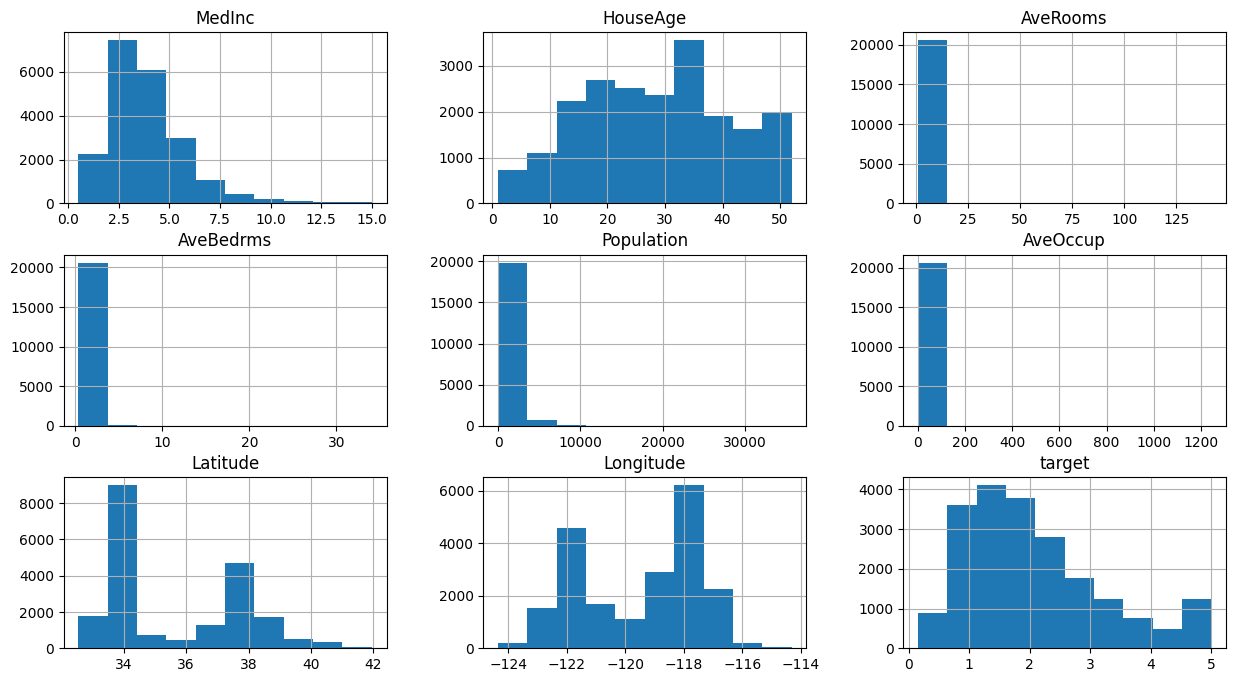

In [14]:
df.hist(figsize=((15,8)))

Из общей картины выбиваются признаки "AveRooms", "AveBedrms", "Population", "AveOccup"

In [15]:
copy_col = col.copy()

In [16]:
copy_col.index('Population')

4

### 4.1 Посмотрим на отношение выбросов без признака "Population" и "target"

In [17]:
del (copy_col[copy_col.index('Population')], copy_col[copy_col.index('target')])

<Axes: >

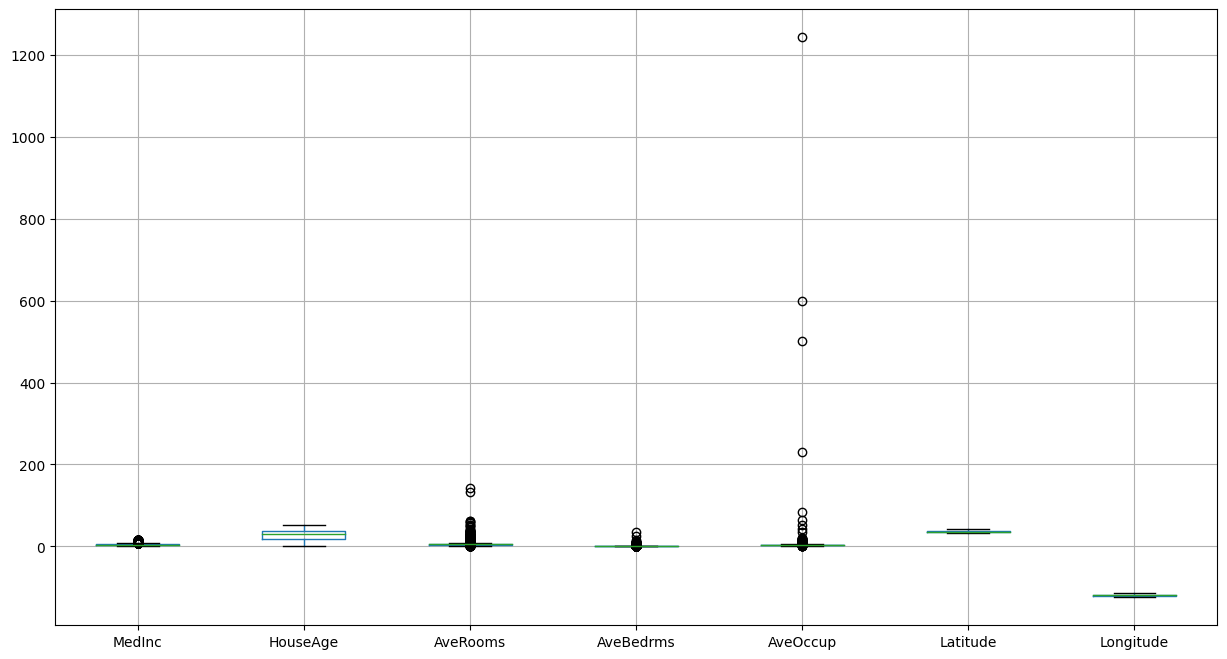

In [18]:
df.boxplot(figsize=((15,8)), column=copy_col)

Из графика видно, что можно ограничить значения по признаку "AveOccup" меньше 200, а для "AveRooms" меньше 20

In [19]:
col_info

[[0, 'MedInc'],
 [1, 'HouseAge'],
 [2, 'AveRooms'],
 [3, 'AveBedrms'],
 [4, 'Population'],
 [5, 'AveOccup'],
 [6, 'Latitude'],
 [7, 'Longitude'],
 [8, 'target']]

In [20]:
copy_col.index('AveOccup'), copy_col.index('AveRooms')

(4, 2)

Посмотрим на получившиеся результаты. Признак "Population" тоже был сокращен до 15000. На график его не включаем так как его значения сильно искажают обзор по отношению к остальным признакам

<Axes: >

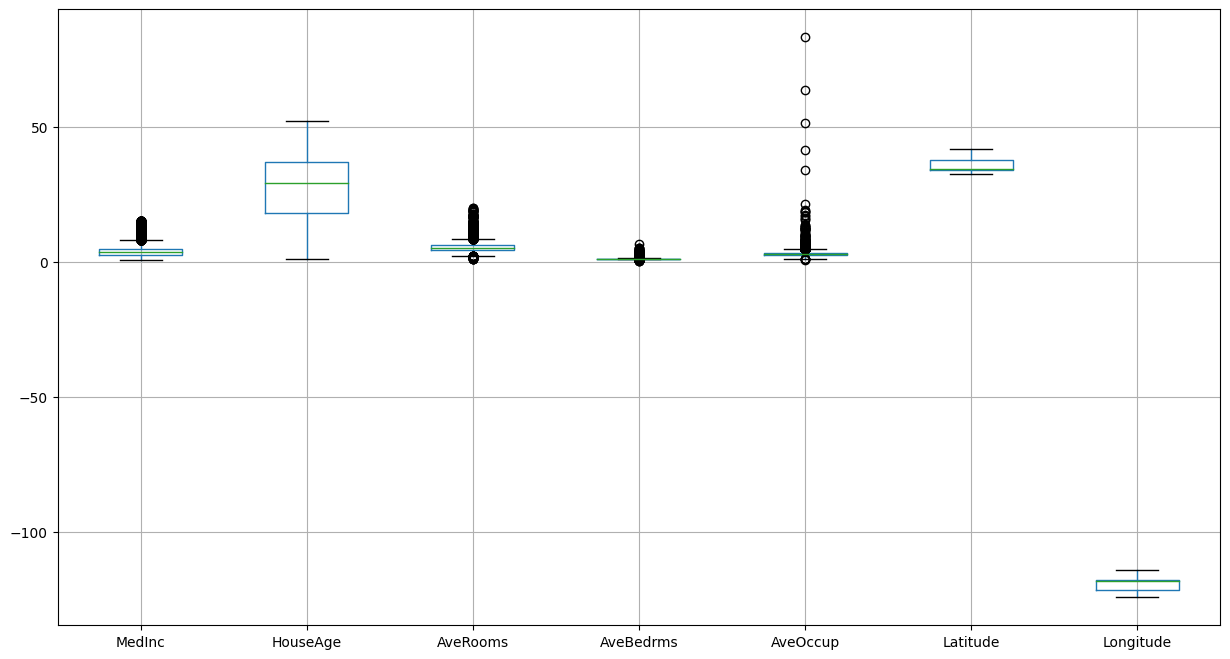

In [21]:
df.loc[(df[copy_col[4]] < 200) & (df[copy_col[2]] < 20) & (df[col[4]] < 15000), copy_col].boxplot(figsize=((15,8)))

### 4.2 Визуализация нового датасета с учетом устраненных выбросов

array([[<Axes: title={'center': 'MedInc'}>,
        <Axes: title={'center': 'HouseAge'}>,
        <Axes: title={'center': 'AveRooms'}>],
       [<Axes: title={'center': 'AveBedrms'}>,
        <Axes: title={'center': 'Population'}>,
        <Axes: title={'center': 'AveOccup'}>],
       [<Axes: title={'center': 'Latitude'}>,
        <Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'target'}>]], dtype=object)

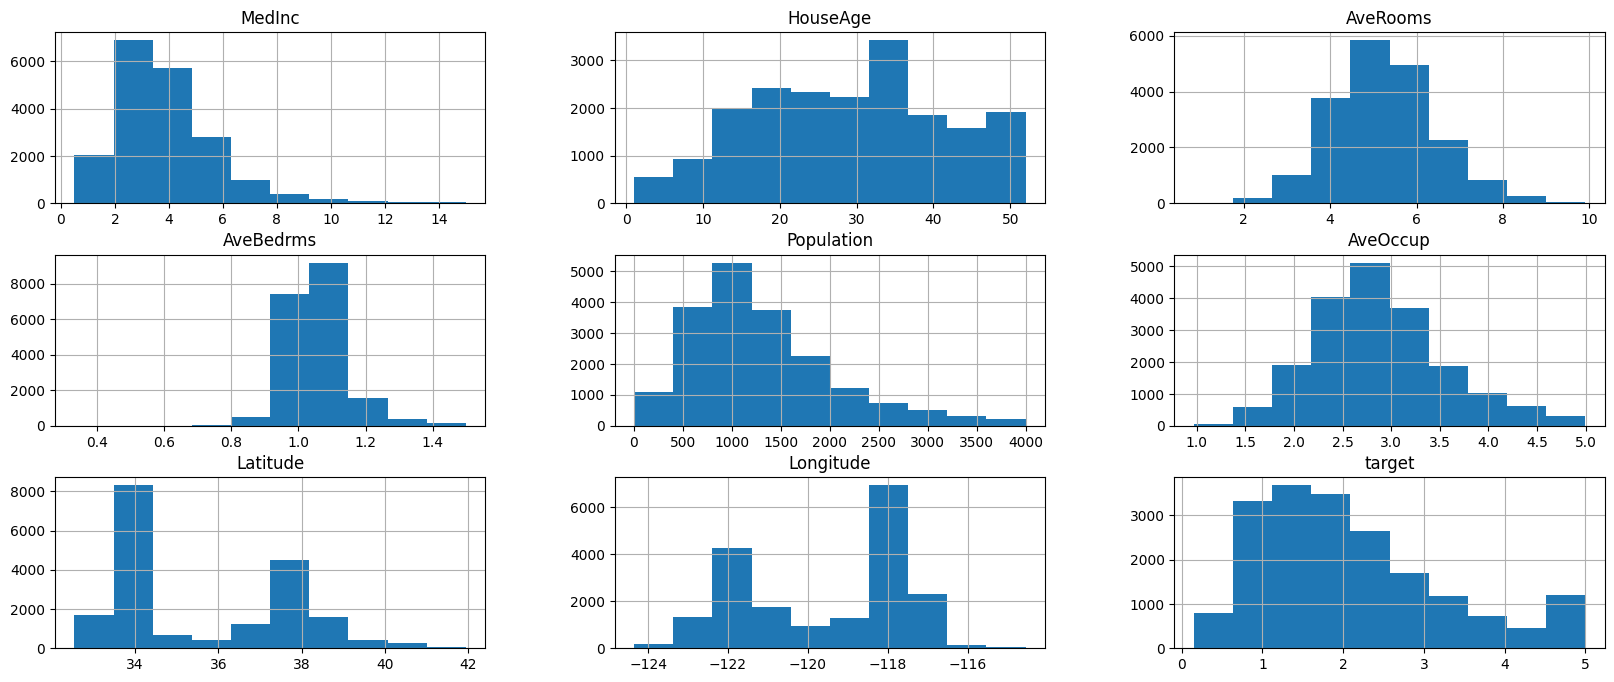

In [22]:
df.loc[(df[copy_col[4]] < 5) & (df[copy_col[2]] < 10) & (df[col[4]] < 4000) & (df[col[3]] < 1.5), col].hist(figsize=((20,8)))

### 4.3 Определение нового датасета

In [23]:
df1 = df.loc[(df[copy_col[4]] < 5) & (df[copy_col[2]] < 10) & (df[col[4]] < 4000) & (df[col[3]] < 1.5), col]

### 4.5 Соотношение датасетов до и после обработки выбросов

In [24]:
print(f"{round((df.shape[0] - df1.shape[0]) / df.shape[0] * 100, 2)} %")

6.84 %


Как результат исходный датасет был уменьшен на 6.83 %, что не значительно по отношению к общей размерности данных

<Axes: >

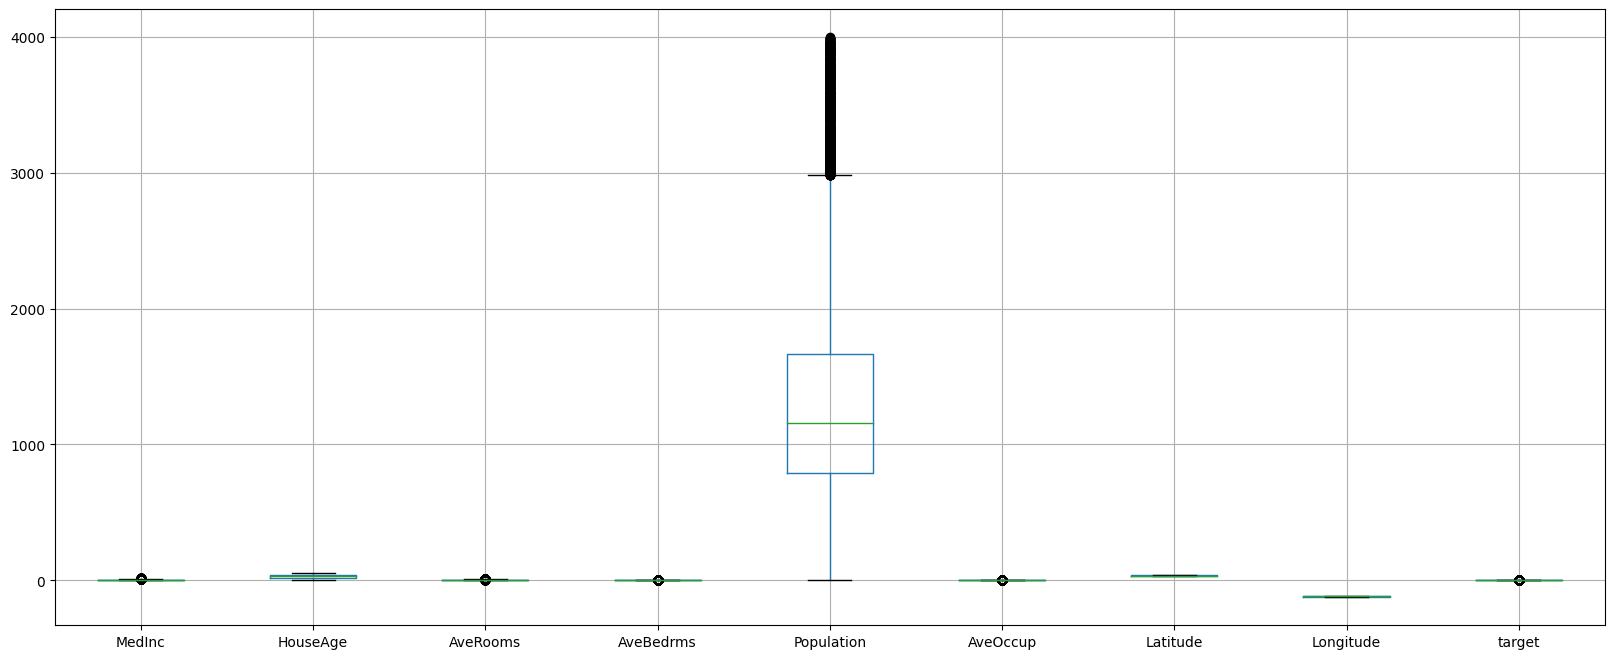

In [25]:
df1.boxplot(figsize=((20,8)))

### 4.6 Визуализация нового датасета

array([[<Axes: title={'center': 'MedInc'}>,
        <Axes: title={'center': 'HouseAge'}>,
        <Axes: title={'center': 'AveRooms'}>],
       [<Axes: title={'center': 'AveBedrms'}>,
        <Axes: title={'center': 'Population'}>,
        <Axes: title={'center': 'AveOccup'}>],
       [<Axes: title={'center': 'Latitude'}>,
        <Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'target'}>]], dtype=object)

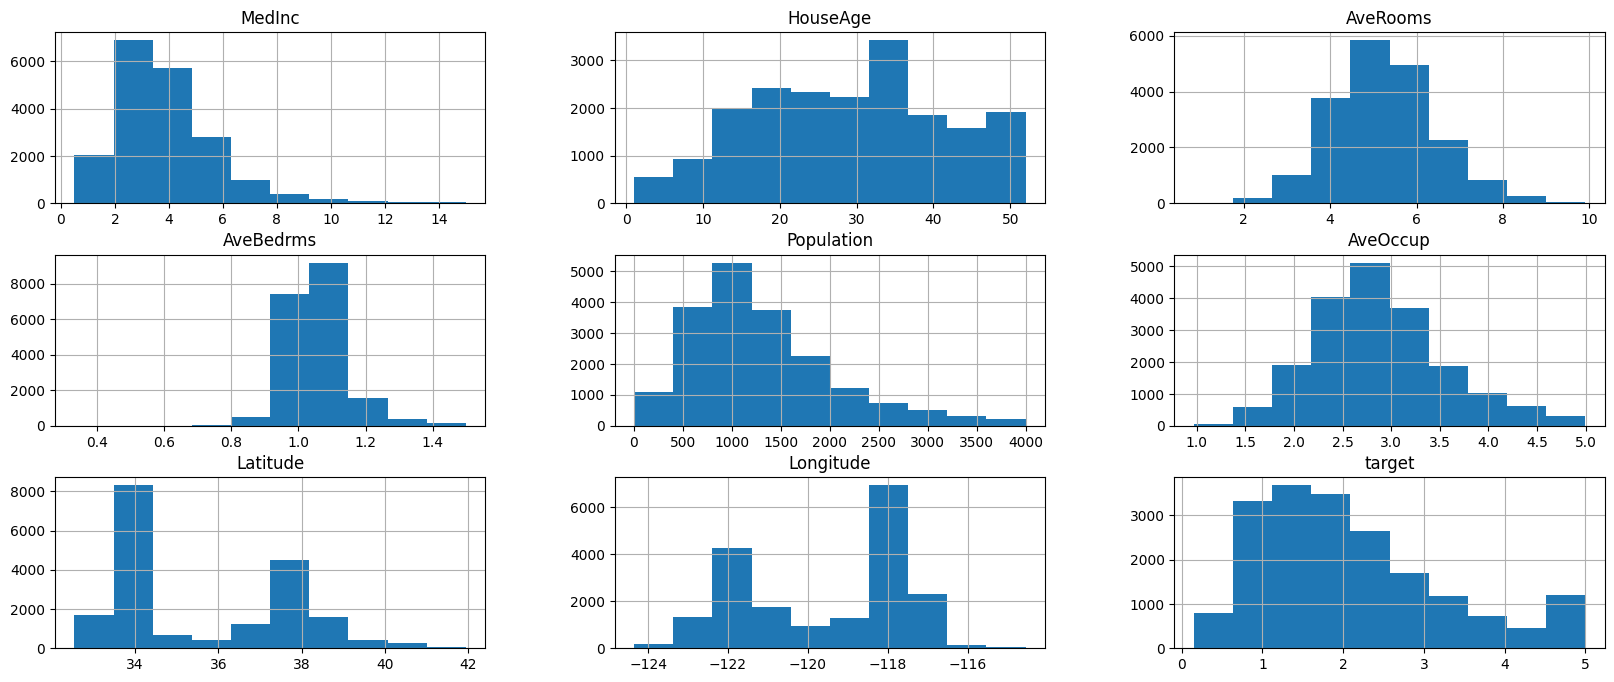

In [26]:
df1.hist(figsize=((20,8)))

## 5 Добавление нового признака

In [27]:
xlong = df1['Longitude']
xlat = df1['Latitude']
dep = df1['target']

### 5.1 Визуализация зависимостей некоторых признаков

В данном случае выполнена визуализация зависимостей:

1 Численность населения от места расположения

2 Целевая переменная от места расположения

Text(0.5, 1.0, 'Target')

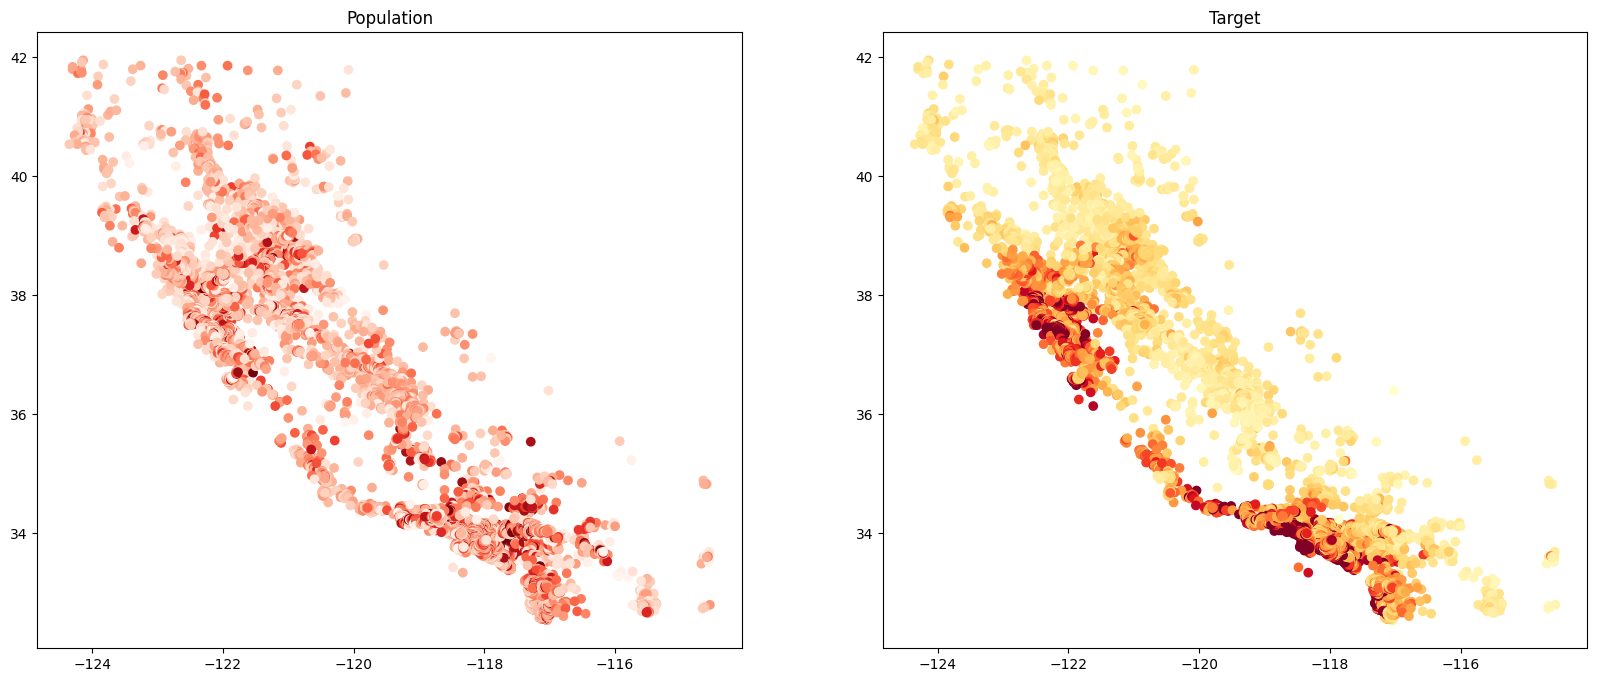

In [28]:
plt.figure(figsize=(20,8))
ax1 = plt.subplot(121)
ax1.scatter(xlong, xlat, c=df1['Population'], cmap='Reds')
ax1.set_title('Population')
ax2 = plt.subplot(122)
ax2.scatter(xlong, xlat, c=df1['target'], cmap='YlOrRd')
ax2.set_title('Target')

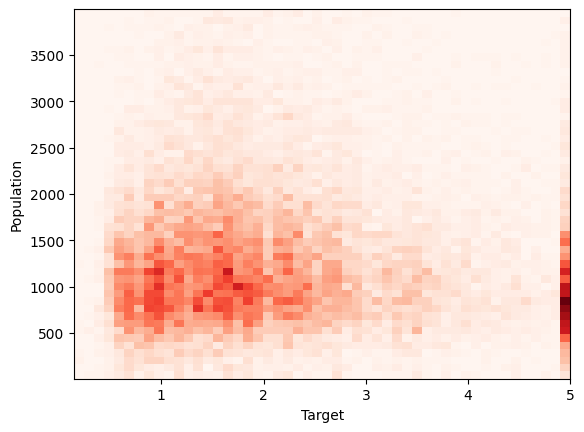

In [29]:
i = 4
plt.hist2d(df1['target'], df1[col[i]], bins=50, cmap='Reds')
plt.xlabel('Target')
plt.ylabel(col[i])
plt.show()

### 5.2 Добавление нового признака

В данном случае будет добавлен новый признак Ocean_proximity, который отражает зависимость изменения таргета т.е. в данном случае цены от удаленности береговой линии

In [30]:
def Approximate_Line(X, y, depth, name_X, name_y):
    pf = np.polyfit(X, y, 1)
    p = np.poly1d(pf)
    plt.scatter(X, y, c=depth, cmap='YlOrRd')
    plt.plot(X, p(X), "g--")
    plt.xlabel(name_X)
    plt.ylabel(name_y)
    plt.grid()
    plt.show()
    return p

Постоим апроксимационную примую в виде полинома 1-й степени

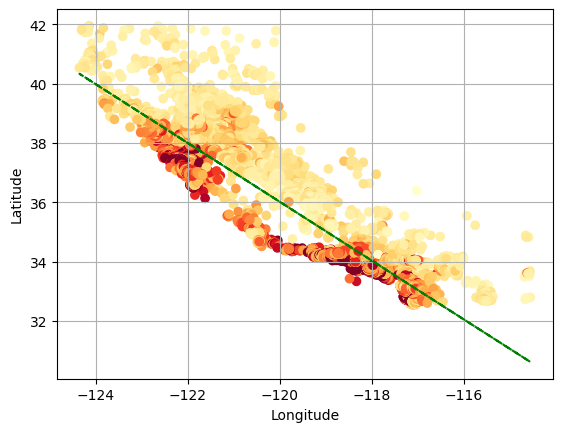

In [31]:
p = Approximate_Line(xlong, xlat, dep, 'Longitude', 'Latitude')

In [32]:
def sigmoid(x_max, x_min, val):
    delta = (x_max - x_min) / 100
    res1 = ((val - x_min) / delta) / 100
    return round(1 - res1, 2)

Введение ромежуточного участока, на котором значения будут меняться от 0 до 1

Где:

1 - береговая линия

0 - материковая зона

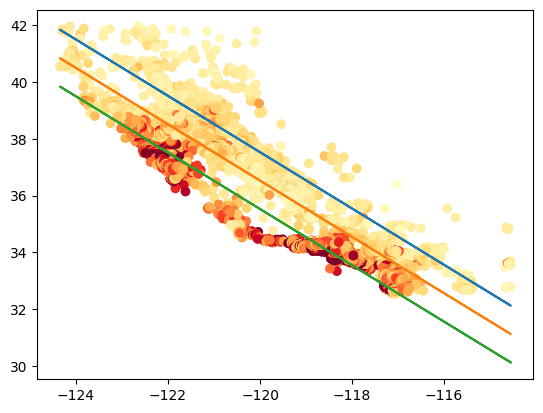

In [33]:
approxim_line = p(xlong) + 1.5
w = 1
w1 = 2
plt.scatter(xlong, xlat, c=df1['target'], cmap='YlOrRd')
plt.plot(xlong, approxim_line)
plt.plot(xlong, approxim_line - w)
plt.plot(xlong, approxim_line - w1)

Разделение значения по упомянутым выше критериям 1  - береговая линия, (от 1 до 0) - переходный участок, 0 - материковая зона

In [34]:
xlat_ar = np.array(xlat)
ocean = []
for l in range(len(approxim_line)):
    if (approxim_line[l] >= xlat_ar[l] >= (approxim_line[l] - 2)):
        res = sigmoid(approxim_line[l], (approxim_line[l] - 2), xlat_ar[l])
        ocean.append(res)
    if xlat_ar[l] >= approxim_line[l]:
        ocean.append(0)
    if xlat_ar[l] <= (approxim_line[l] - 2):
        ocean.append(1)

In [35]:
df1['Ocean_proximity'] = ocean

Визуализация зависимости долготы от широты, где интенсивность цвета определяет удаленность от береговой линии

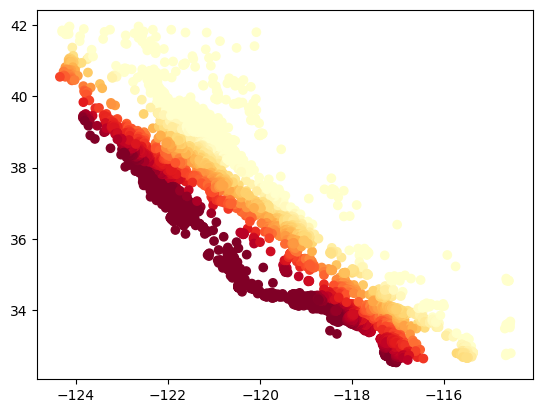

In [36]:
plt.scatter(xlong, xlat, c=df1['Ocean_proximity'], cmap='YlOrRd')

In [37]:
col = df1.columns.to_list()

In [38]:
col_info = []
for i in range(len(col)):
    col_info.append([i, col[i]])
col_info

[[0, 'MedInc'],
 [1, 'HouseAge'],
 [2, 'AveRooms'],
 [3, 'AveBedrms'],
 [4, 'Population'],
 [5, 'AveOccup'],
 [6, 'Latitude'],
 [7, 'Longitude'],
 [8, 'target'],
 [9, 'Ocean_proximity']]

In [39]:
col_info

[[0, 'MedInc'],
 [1, 'HouseAge'],
 [2, 'AveRooms'],
 [3, 'AveBedrms'],
 [4, 'Population'],
 [5, 'AveOccup'],
 [6, 'Latitude'],
 [7, 'Longitude'],
 [8, 'target'],
 [9, 'Ocean_proximity']]

## 6 Запись датасета в собственный класс

In [40]:
class MyOwn_CaliforniaHousing(torch.utils.data.Dataset):

    def __init__(self, init_dataset):
        self._base_dataset = init_dataset

    def __len__(self, col=False):
        if col == True:
            return self._base_dataset.columns.to_list()
        else:
            return len(self._base_dataset)

    def __getitem__(self, idx):
        """Возвращает значение по индексу"""
        if idx is not None:
            return self._base_dataset[idx]

## 7 Разделение датасета на тренировочный, валидационный и тестовый

Для теста отдадим 15 % значений которые не будут участвовать в процессе обучения

In [41]:
target = df1['target']
df1.pop('target')
# df1.drop(columns=['Latitude', 'Longitude'], inplace=True)
df1['target'] = target
df1.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'Ocean_proximity', 'target'],
      dtype='object')

In [42]:
col = df1.columns.to_list()

In [43]:
test_data = df1[:int(df1.shape[0] * 0.15 // 1)]

Просмотр размерности тестового датасета

In [44]:
test_data.shape

(2884, 10)

Определение размерности тренировочного датасета

In [45]:
train_data = df1[col[:-1]]
train_data.shape

(19229, 9)

Определение размерности валидационного датасета

In [46]:
labels_data = df1[col[-1]]
labels_data.shape

(19229,)

### 7.1 Разбиение отсортированых данных на тренировочные и валидационные

In [47]:
x_train, x_val, y_train, y_val = train_test_split(train_data, labels_data, test_size=0.25, random_state=13)

### 7.2 Нормализация Данных

Для нормализации данных воспользуемя библиотекой sklearn методом StandardScaler

In [48]:
# min_max_scal = StandardScaler()
min_max_scal = MinMaxScaler()

x_train = min_max_scal.fit_transform(x_train)
x_val = min_max_scal.fit_transform(x_val)

y_train = np.expand_dims(y_train, axis=1)
y_val = np.expand_dims(y_val, axis=1)

y_train = min_max_scal.fit_transform(y_train)
y_val = min_max_scal.fit_transform(y_val)

Просмотр размерностей датасетов

In [49]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((14421, 9), (4808, 9), (14421, 1), (4808, 1))

In [50]:
x_train = np.array(x_train)
x_val = np.array(x_val)
y_train = np.array(y_train)
y_val = np.array(y_val)
train_xt=torch.from_numpy(x_train.astype(np.float32))
train_yt=torch.from_numpy(y_train.astype(np.float32))
test_xt=torch.from_numpy(x_val.astype(np.float32))
test_yt=torch.from_numpy(y_val.astype(np.float32))

### 7.3 Запись датасета в DataLoader

In [51]:
train_dataset_to_tensor=Data.TensorDataset(train_xt,train_yt)
test_dataset_to_tensor=Data.TensorDataset(test_xt,test_yt)
train_dataset = MyOwn_CaliforniaHousing(train_dataset_to_tensor)
test_dataset = MyOwn_CaliforniaHousing(test_dataset_to_tensor)
# train_dataset.__len__() // 300
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=48, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=True, drop_last=True)
len(train_loader), len(test_loader)

(300, 48)

## 8 Определение/создание модели

In [52]:
from cycler import L
class Dense_Layer(nn.Module):

    def __init__(self, input_dim, output_dim, activation='relu'):
        super().__init__()
        """Определение полносвязного слоя.
            input_dim - Количество нейронов на входе в слой,
            output_dim - Количество нейронов на выходе из слоя,
            activation - Функция активации слоя ('relu' или 'sigmoid')"""
        self.Dense = nn.Linear(input_dim, output_dim)
        self.activation = activation

    def forward(self, x):
        x = self.Dense(x)
        if self.activation == 'relu':
            return F.relu(x)
        if self.activation == 'sigmoid':
            return F.sigmoid(x)
        if self.activation == 'tanh':
            return F.tanh(x)
        raise RuntimeError

class MyModel(nn.Module):

    def __init__(self, input_dims, dim_list, dp_list, output_dims):
        super().__init__()
        """Определение структуры модели.
            input_dim - Входной массив/количество нейронов на входе в модель,
            dim_list - Список значений определяющий количество нейронов на
            выходе каждого слоя,
            dp_list - Список значений определяющих долю выключеных нейронов на
            каждом слое,
            output_dim - Количество нейронов на выходе из модели"""
        self.d1 = Dense_Layer(input_dims, dim_list[0])

        self.d2 = Dense_Layer(dim_list[0], dim_list[1])
        self.bn1 = nn.BatchNorm1d(dim_list[1])
        self.dp1 = nn.Dropout(dp_list[0])

        self.d3 = Dense_Layer(dim_list[1], dim_list[2])
        self.bn2 = nn.BatchNorm1d(dim_list[2])
        self.dp2 = nn.Dropout(dp_list[1])

        self.d4 = Dense_Layer(dim_list[2], dim_list[3])
        self.bn3 = nn.BatchNorm1d(dim_list[3])
        self.dp3 = nn.Dropout(dp_list[2])

        self.d5 = Dense_Layer(dim_list[3], dim_list[4])
        self.d6 = Dense_Layer(dim_list[4], output_dims, 'sigmoid')

    def forward(self, Inputs):
        """Сборка модели"""
        l = self.d1(Inputs)

        l = self.d2(l)
        l = self.bn1(l)
        l = self.dp1(l)

        l = self.d3(l)
        l = self.bn2(l)
        l = self.dp2(l)

        l = self.d4(l)
        l = self.bn3(l)
        l = self.dp3(l)

        l = self.d5(l)
        Output = self.d6(l)
        return Output

### 8.1 Определение параметров для слоев модели

In [53]:
input_shape = x_train.shape[1]
output_shape = 1
dim_list = [100, 78, 64, 32, 16, 1]
dropout_list = [0.4, 0.3, 0.2]

In [54]:
model1 = MyModel(input_shape, dim_list, dropout_list, output_shape)

In [55]:
model2 = MyModel(input_shape, dim_list, dropout_list, output_shape)

In [56]:
model3 = MyModel(input_shape, dim_list, dropout_list, output_shape)

### 8.2 Опрделение оптимизаторов и функций потерь

In [57]:
optimizer_sgd = opt.SGD(model1.parameters(), lr=0.001)
optimizer_adam = opt.Adam(model2.parameters(), lr=0.001)
optimizer_rmsp = opt.RMSprop(model3.parameters(), lr=0.001)

loss_mse = nn.MSELoss(reduction='sum')

## 9 Обучение моделей

In [58]:
def FitModel(Model, X, y, model_epochs, model_optimizers, model_losses):
    train_accuracy_all = []
    train_loss_all = []
    start = time.time()
    for epoch in range(model_epochs):
        running_loss, running_items, running_right = 0.0, 0.0, 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data[0], data[1]


            # обнуляем градиент
            model_optimizers.zero_grad()
            outputs = Model(inputs)                # Предсказание
            loss = model_losses(outputs, labels)    # Ошибка
            loss.backward()                      # Градиенты
            model_optimizers.step()                     # Шаг оптимизации

            # выводим статистику о процессе обучения
            running_loss += loss.item()
            running_items += len(labels)
            running_right += (labels == torch.max(outputs, 1)[1]).sum()

            # выводим статистику о процессе обучения
            if i % 150 == 0:    # печатаем каждые 300 mini-batches
                Model.eval()

                print("", end=f'\rEpoch [{epoch + 1}/{model_epochs}]. ' \
                            f'Loss: {running_loss / running_items:.3f}. ' \
                            f'Acc: {running_right / running_items:.3f}. ')
                train_accuracy_all.append(running_right / running_items)
                train_loss_all.append(running_loss / running_items)

                running_loss, running_items, running_right = 0.0, 0.0, 0.0

                test_running_right, test_running_total = 0.0, 0.0
                for i, data in enumerate(test_loader):

                    test_outputs = Model(data[0])
                    test_running_total += len(data[1])
                    test_running_right += (data[1] == torch.max(test_outputs, 1)[1]).sum()

                print("", end=f'Test acc: {test_running_right / test_running_total:.3f}')
                Model.train()

    stop = time.time()
    print(f'\nTraining is finished! It took {round((stop - start), 2)} seconds')
    plt.plot(train_loss_all)
    plt.show()
    return train_accuracy_all, train_loss_all

### 9.1 Обучение модели с оптимизатором SGD

Epoch [50/50]. Loss: 0.016. Acc: 0.007. Test acc: 0.021
Training is finished! It took 46.84 seconds


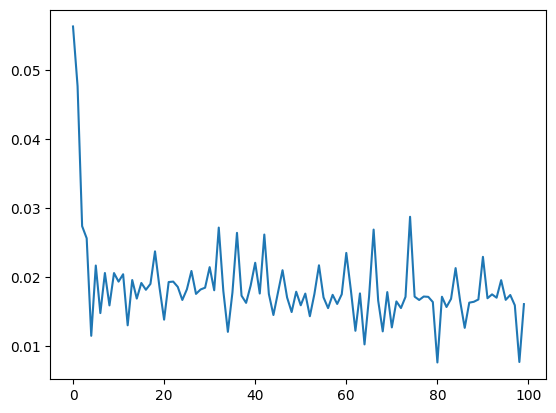

In [59]:
acc_sgd, loss_sgd = FitModel(model1, train_loader, test_loader, 50, optimizer_sgd, loss_mse)

### 9.2 Обучение модели с оптимизатором Adam

Epoch [50/50]. Loss: 0.014. Acc: 0.007. Test acc: 0.021
Training is finished! It took 64.48 seconds


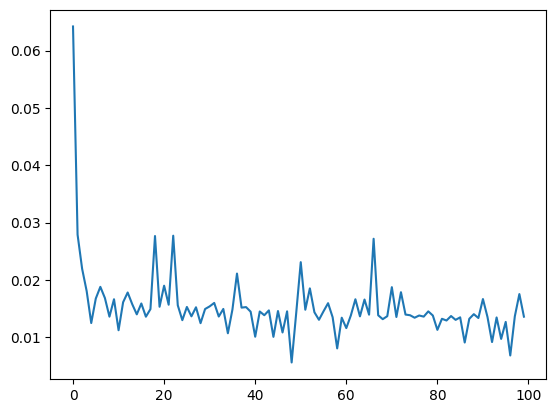

In [60]:
acc_adam, loss_adam = FitModel(model2, train_loader, test_loader, 50, optimizer_adam, loss_mse)

### 9.3 Обучение модли с оптимизатором RMSprop

Epoch [30/30]. Loss: 0.014. Acc: 0.000. Test acc: 0.021
Training is finished! It took 34.85 seconds


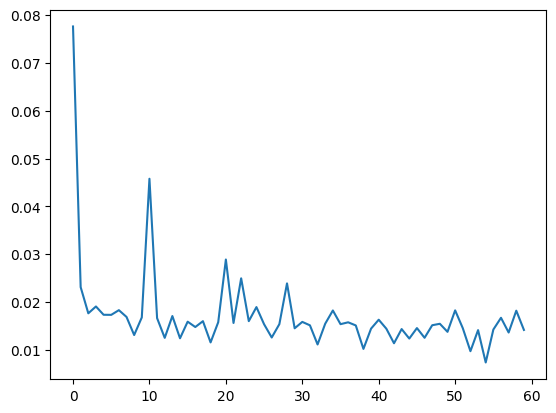

In [61]:
acc_rmsp, loss_rmsp = FitModel(model3, train_loader, test_loader, 30, optimizer_rmsp, loss_mse)

На основе выведеных выше трех графиков можно выделить модель с оптимизатором Adam, так как для данной модели график функции потерь меньший разброс значений и более сглаженную сходимость

## 10 Используемые дополнительные материалы

https://captum.ai/tutorials/House_Prices_Regression_Interpret

https://russianblogs.com/article/27723109519/